### Importing Libraries

In [2]:
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import matplotlib.pyplot as plot
from keras.utils import np_utils
import pandas as pd

from IPython.display import display
import time
from tqdm import tqdm

# Nelder-Mead using SGD Optimiser

In [3]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

n=30000
x_train = x_train[1:n]
y_train=y_train[1:n]

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
def create_NelderMead_SGD_model(parameters):
    
    selectedLearningRate = parameters[0]
    selectedBatchSize = int(parameters[1])
    
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    optimizer = SGD(learning_rate = selectedLearningRate)
    
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [5]:
trainingLoss_data = []
validationLoss_data = []
bestTrainingLoss_data = []
bestValidationLoss_data = []

currentBestTrainingLoss = currentBestValidationLoss = float("inf")

testLoss_data = []
bestTestLoss_data = []
currentBestTestLoss = float("inf")
optimisedParameters = {}

def tune_NelderMead_SGD_model(parameters):
    global currentBestValidationLoss
    global currentBestTrainingLoss
    global currentBestTestLoss
    global optimisedParameters
    
    parameters[0] = np.clip(parameters[0], 1e-4, 1e-1)
    parameters[1]  = np.clip(parameters[1], 16, 128)

    model = create_NelderMead_SGD_model(parameters)
    history = model.fit(x_train, y_train, epochs=10, batch_size=int(parameters[1]), validation_data=(x_validation, y_validation), verbose=0)
    validationLoss = history.history['val_loss'][-1]
    trainingLoss = history.history['loss'][-1]
    
    trainingLoss_data.append(trainingLoss)
    validationLoss_data.append(validationLoss)
        
    if validationLoss < currentBestValidationLoss:
        currentBestValidationLoss = validationLoss
    
    if trainingLoss < currentBestTrainingLoss:
        currentBestTrainingLoss = trainingLoss
    
    bestTrainingLoss_data.append(currentBestTrainingLoss)
    bestValidationLoss_data.append(currentBestValidationLoss)
    
    testLoss, testAccuracy = model.evaluate(x_test, y_test, batch_size=int(parameters[1]), verbose=0)
    
    testLoss_data.append(testLoss)
    
    if testLoss < currentBestTestLoss:
        currentBestTestLoss = testLoss
        optimisedParameters = {
                                    "Learning Rate": parameters[0],
                                    "Batch Size": int(parameters[1]),
                                    "Test Accuracy": testAccuracy,
                                    "Test Loss": testLoss
                              }
    bestTestLoss_data.append(currentBestTestLoss)
    return validationLoss

In [6]:
initial_parameters = [0.001, 32]
start_time = time.time()
n_iterations = 20
with tqdm(total=n_iterations-1) as pbar:
    def tqdm_callback(x):
        pbar.update(1)

    minimize(tune_NelderMead_SGD_model, x0=initial_parameters, options={'maxiter': n_iterations}, callback=tqdm_callback, method='Nelder-Mead')
end_time = time.time()
print(f'\n\nTotal time to execute Nelder-Mead(SGD) is : {end_time - start_time} seconds')

100%|██████████| 19/19 [46:54<00:00, 148.15s/it]



Total time to execute Nelder-Mead(SGD) is : 2814.7720103263855 seconds


In [7]:
NelderMead_Test_Parameters_df = pd.DataFrame([optimisedParameters])
display(NelderMead_Test_Parameters_df)

,Learning Rate,Batch Size,Test Accuracy,Test Loss
0,0.1,16,0.9891,0.030602


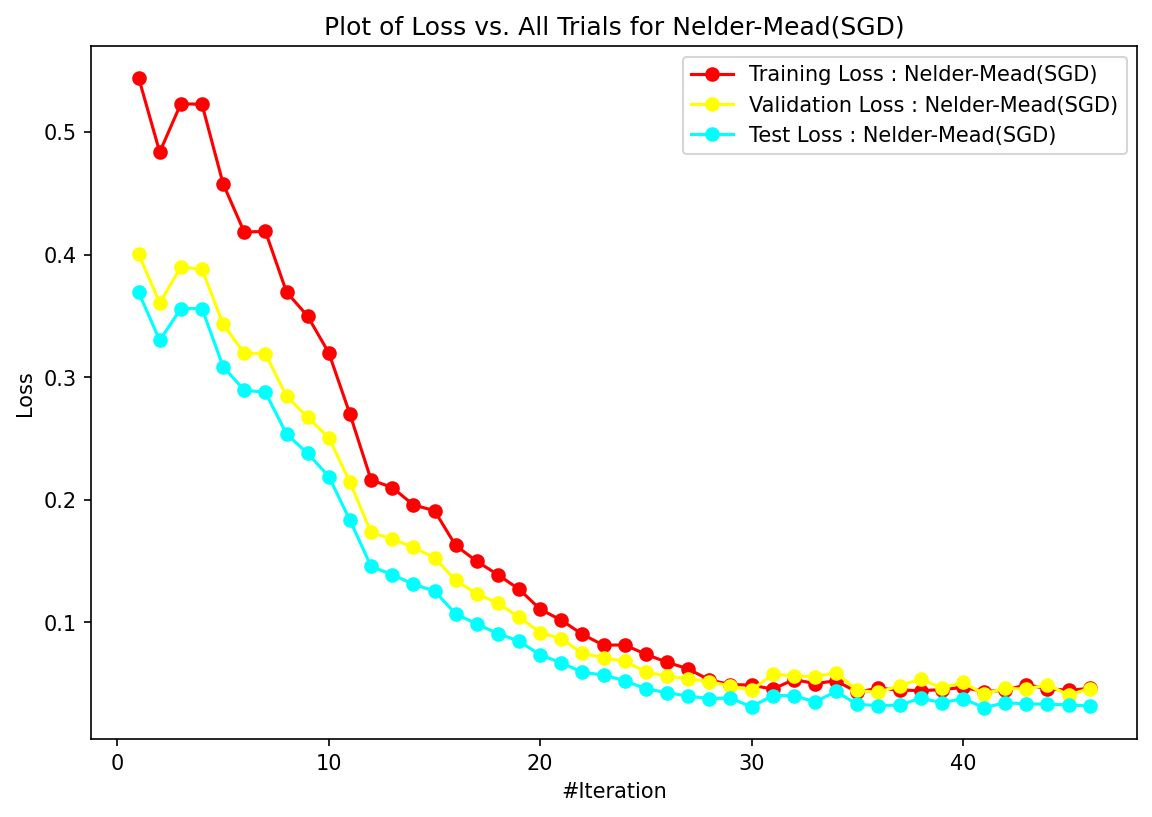

In [8]:
plot.figure(figsize=(9, 6), dpi=150)     
plot.plot(range(1, len(trainingLoss_data) + 1), trainingLoss_data, label="Training Loss : Nelder-Mead(SGD)", marker='o', color="Red")
plot.plot(range(1, len(validationLoss_data) + 1), validationLoss_data, label="Validation Loss : Nelder-Mead(SGD)", marker='o', color="Yellow")
plot.plot(range(1, len(testLoss_data) + 1), testLoss_data, label="Test Loss : Nelder-Mead(SGD)", marker='o', color="Cyan")
plot.xlabel("#Iteration")
plot.ylabel("Loss")
plot.title('Plot of Loss vs. All Trials for Nelder-Mead(SGD)')
plot.legend()
plot.show()

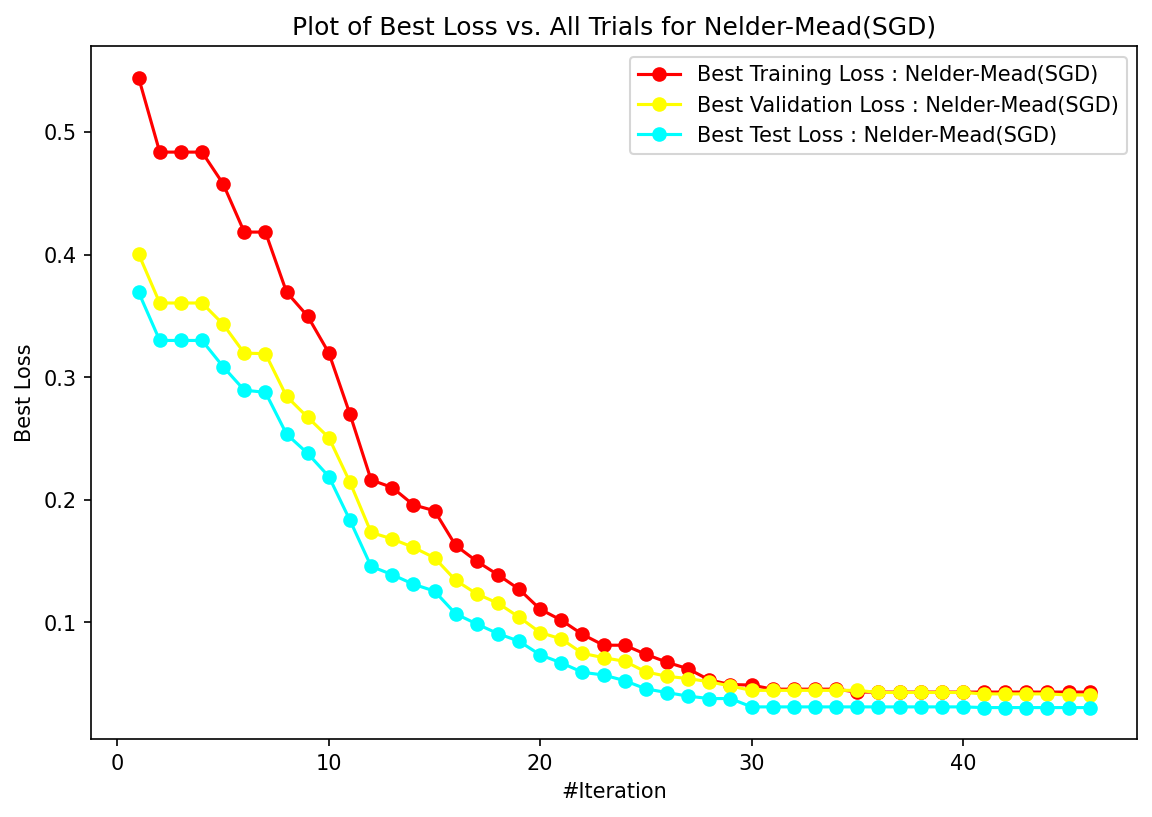

In [9]:
plot.figure(figsize=(9, 6), dpi=150)     
plot.plot(range(1, len(bestTrainingLoss_data) + 1), bestTrainingLoss_data, label="Best Training Loss : Nelder-Mead(SGD)", marker='o', color="Red")
plot.plot(range(1, len(bestValidationLoss_data) + 1), bestValidationLoss_data, label="Best Validation Loss : Nelder-Mead(SGD)", marker='o', color="Yellow")
plot.plot(range(1, len(bestTestLoss_data) + 1), bestTestLoss_data, label="Best Test Loss : Nelder-Mead(SGD)", marker='o', color="Cyan")
plot.xlabel("#Iteration")
plot.ylabel("Best Loss")
plot.title('Plot of Best Loss vs. All Trials for Nelder-Mead(SGD)')
plot.legend()
plot.show()

In [10]:
bestTest_NM_SGD_DF = pd.DataFrame(bestTestLoss_data, columns=['BestTestLoss_NM_SGD'])
bestTest_NM_SGD_DF.to_csv('NM_SGD_BestTestLoss.csv', index=False)